### Python画气象图

用到的Python库，xarray，matplotlib,pandas,proplot,cmaps ...

以下个例使用GFS的grib2格式预报数据，使用eccodes或wgrib2作预处理

以eccodes为例，使用grib_ls或grib_dump查看grib文件信息

使用grib_copy提取2米温度变量
```bash
grib_copy -w shortName=2t gfs.t00z.pgrb2.0p25.f024 gfs.2021040300.pgrb2.0p25_2t.f024
```

提取降水变量
```bash
grib_copy -w shortName=tp,stepRange=0-24 gfs.t00z.pgrb2.0p25.f024 gfs.2021040300.pgrb2.0p25_tp.f024
```

提取10米风
```bash
grib_copy -w typeOfLevel=heightAboveGround,level=10 gfs.t00z.pgrb2.0p25.f024 gfs.2021040300.pgrb2.0p25_10wind.f024
```

#### 1 提取shp文件

In [1]:
# 引入需要的库
import numpy as np
import pandas as pd
from matplotlib.path import Path
import xarray as xr
import proplot as plot
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.mpl.patch import geos_to_path
from cartopy.feature import ShapelyFeature
from shapely.geometry import MultiPolygon
import cmaps

# 读取行政边界文件shapefile
# China shapefile
# https://github.com/dongli/china-shapefiles
#
# modify cartopy source as follow:
# https://github.com/SciTools/cartopy/issues/1282

fname = 'shapefiles/china.shp'
shape_records = Reader(fname).records()

chn_geoms = []
for country in shape_records:
    name = country.attributes['FCNAME'].rstrip('\x00')
    chn_geoms += [country.geometry]
    if name == '甘肃省':
        geoms  = [ country.geometry ]
        gs_geoms = MultiPolygon([country.geometry])
        path   = Path.make_compound_path(*geos_to_path(geoms))
chn_geoms = MultiPolygon(chn_geoms)

# 定义中文字体
cnfont = {'fontname':'simhei'}
cnfont_f = {'fontname':'fangsong'}

#### 2 画2米温度

<xarray.Dataset>
Dimensions:            (latitude: 61, longitude: 101)
Coordinates:
  * latitude           (latitude) float64 30.0 30.25 30.5 ... 44.5 44.75 45.0
    time               datetime64[ns] ...
    step               timedelta64[ns] ...
    heightAboveGround  int32 ...
  * longitude          (longitude) float64 90.0 90.25 90.5 ... 114.5 114.8 115.0
    valid_time         datetime64[ns] ...
Data variables:
    t2m                (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP 
    history:                 2021-04-03T20:46:19 GRIB to CDM+CF via cfgrib-0....


C:\Users\HP\miniconda3\envs\metenv\lib\site-packages\proplot\figure.py:1158: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  return super().colorbar(*args, cax=cax, **kwargs)


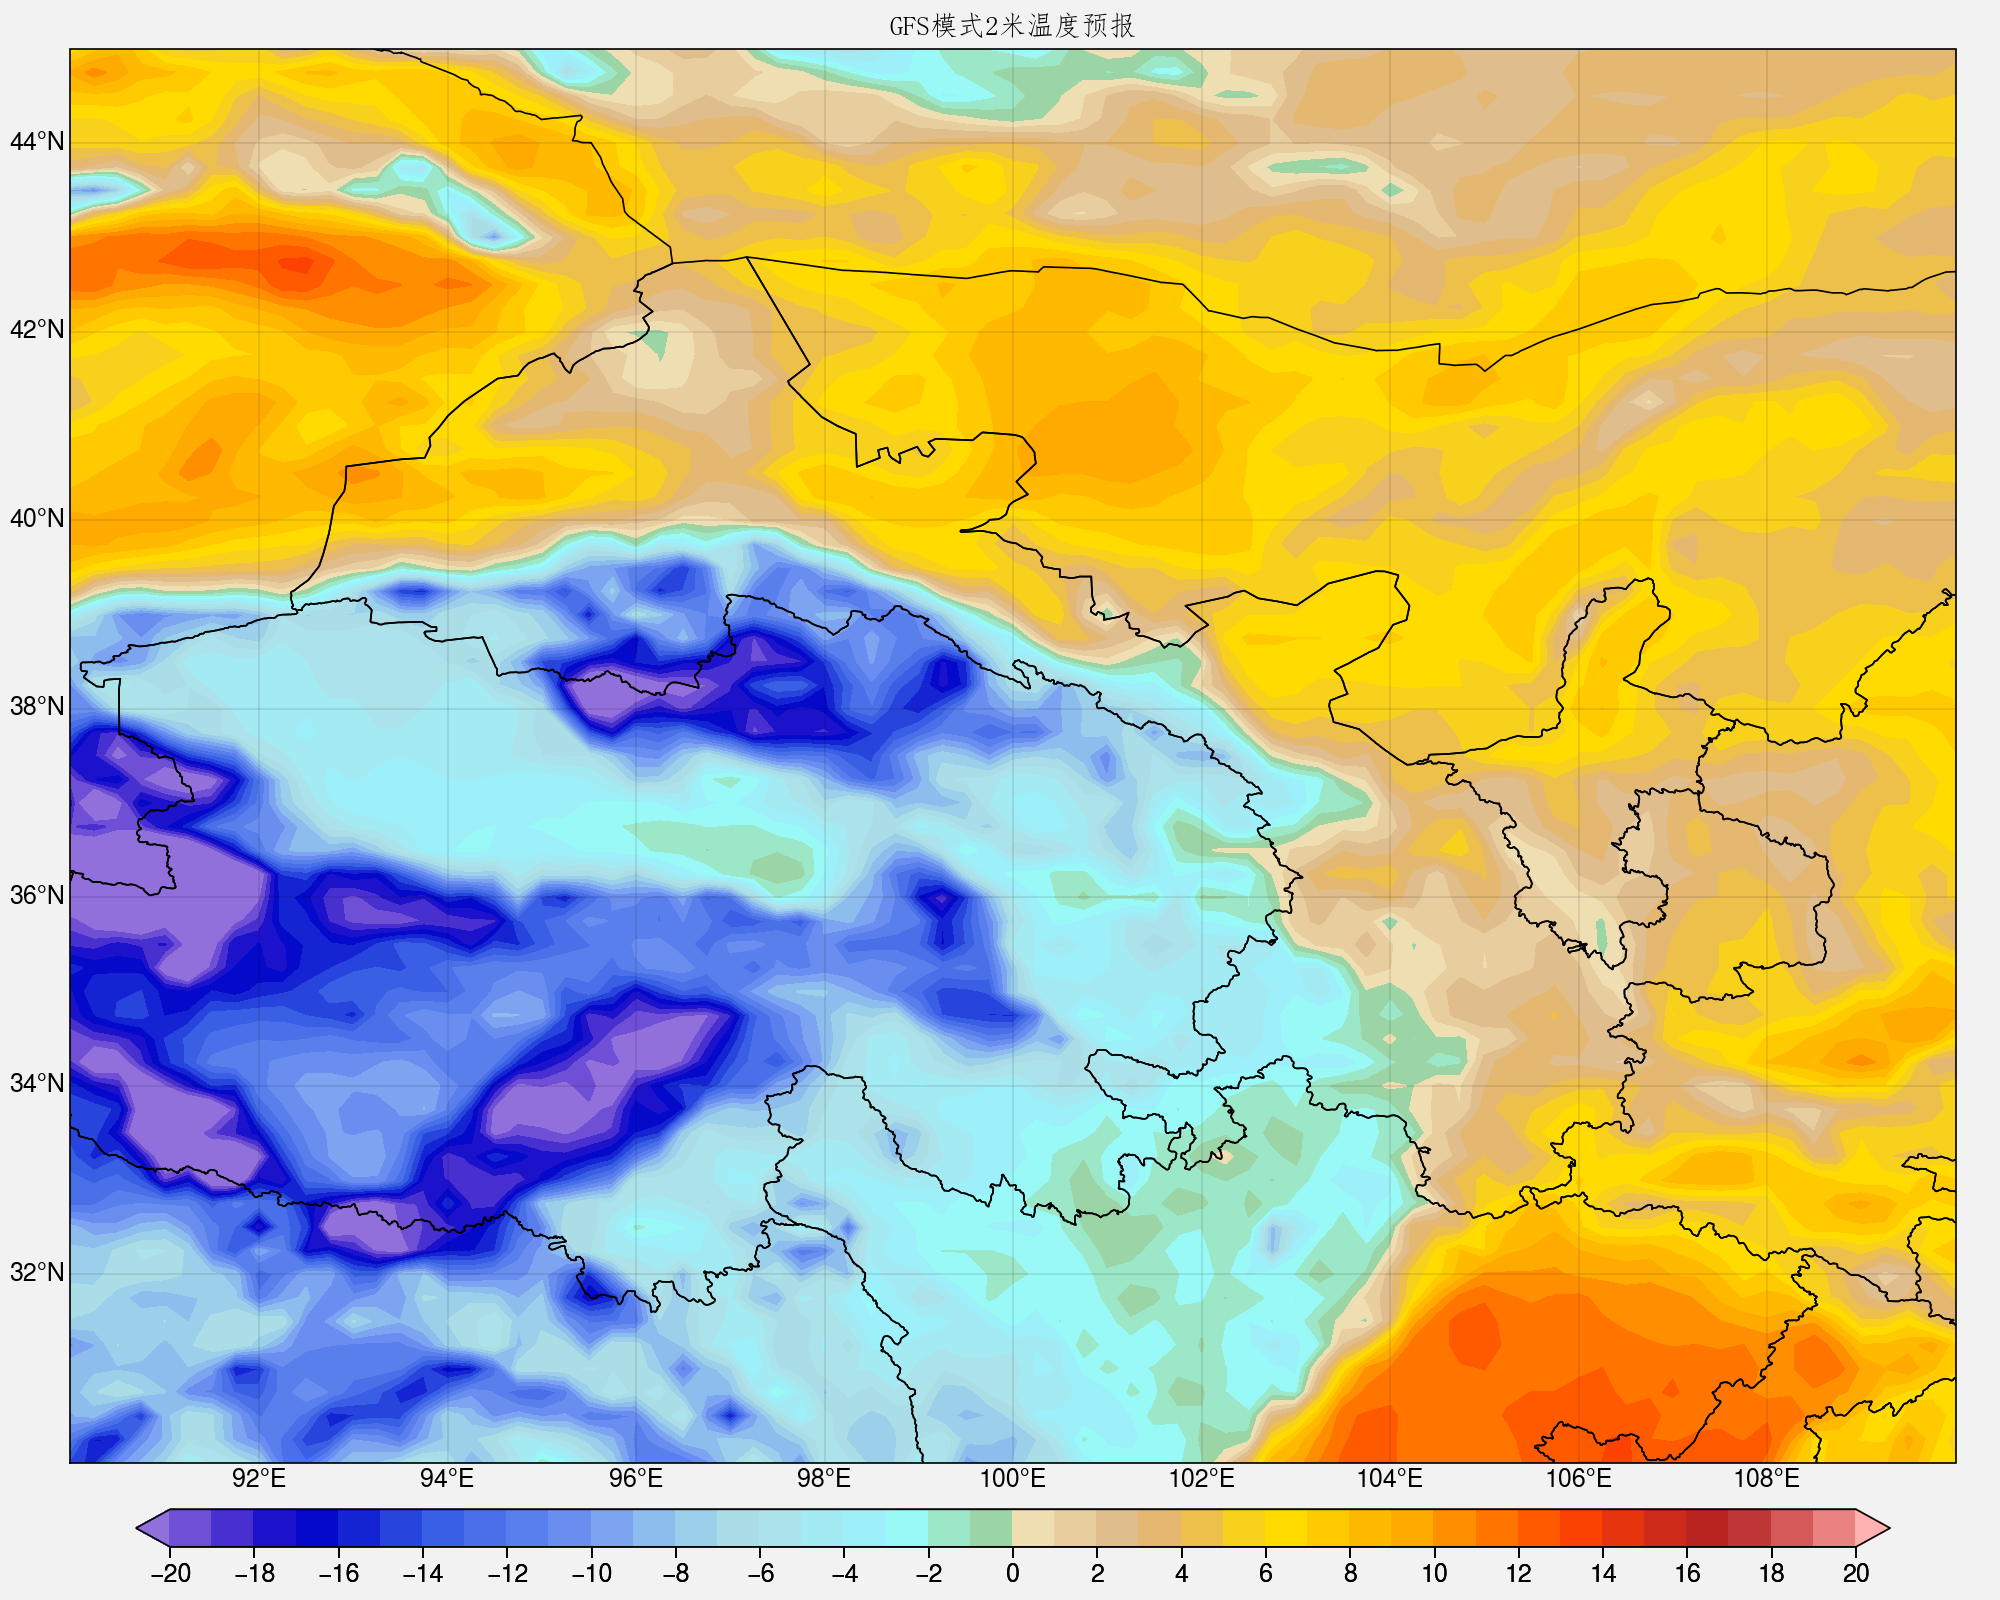

In [2]:
ds = xr.open_dataset('gfs.2021040300.pgrb2.0p25_2t.f024', engine='cfgrib', backend_kwargs={'indexpath':''})
ds = ds.reindex(latitude=ds.latitude[::-1])
ds = ds.sel(longitude=slice(90,115),latitude=slice(30,45))
print(ds)

f, axs = plot.subplots(ncols=1, nrows=1, figsize=(10,8),proj='pcarree' )
axs.format(
    labels=True,latlines=2, lonlines=2,lonlim=(90,110),latlim=(30,45),
    suptitle=''
)
 
im = axs[0].contourf(ds.longitude, ds.latitude, ds.t2m -273.15, cmap=cmaps.amwg256, levels=np.linspace(-20,20,41), extend='both')
axs[0].colorbar(im, loc='b', length=0.9)
axs[0].format(title='GFS模式2米温度预报',**cnfont_f)

shape_feature = ShapelyFeature(chn_geoms, ccrs.PlateCarree(), facecolor='none',edgecolor='k')
axs[0].add_feature(shape_feature)

#### 3 画10米风场

C:\Users\HP\miniconda3\envs\metenv\lib\site-packages\proplot\figure.py:1158: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  return super().colorbar(*args, cax=cax, **kwargs)


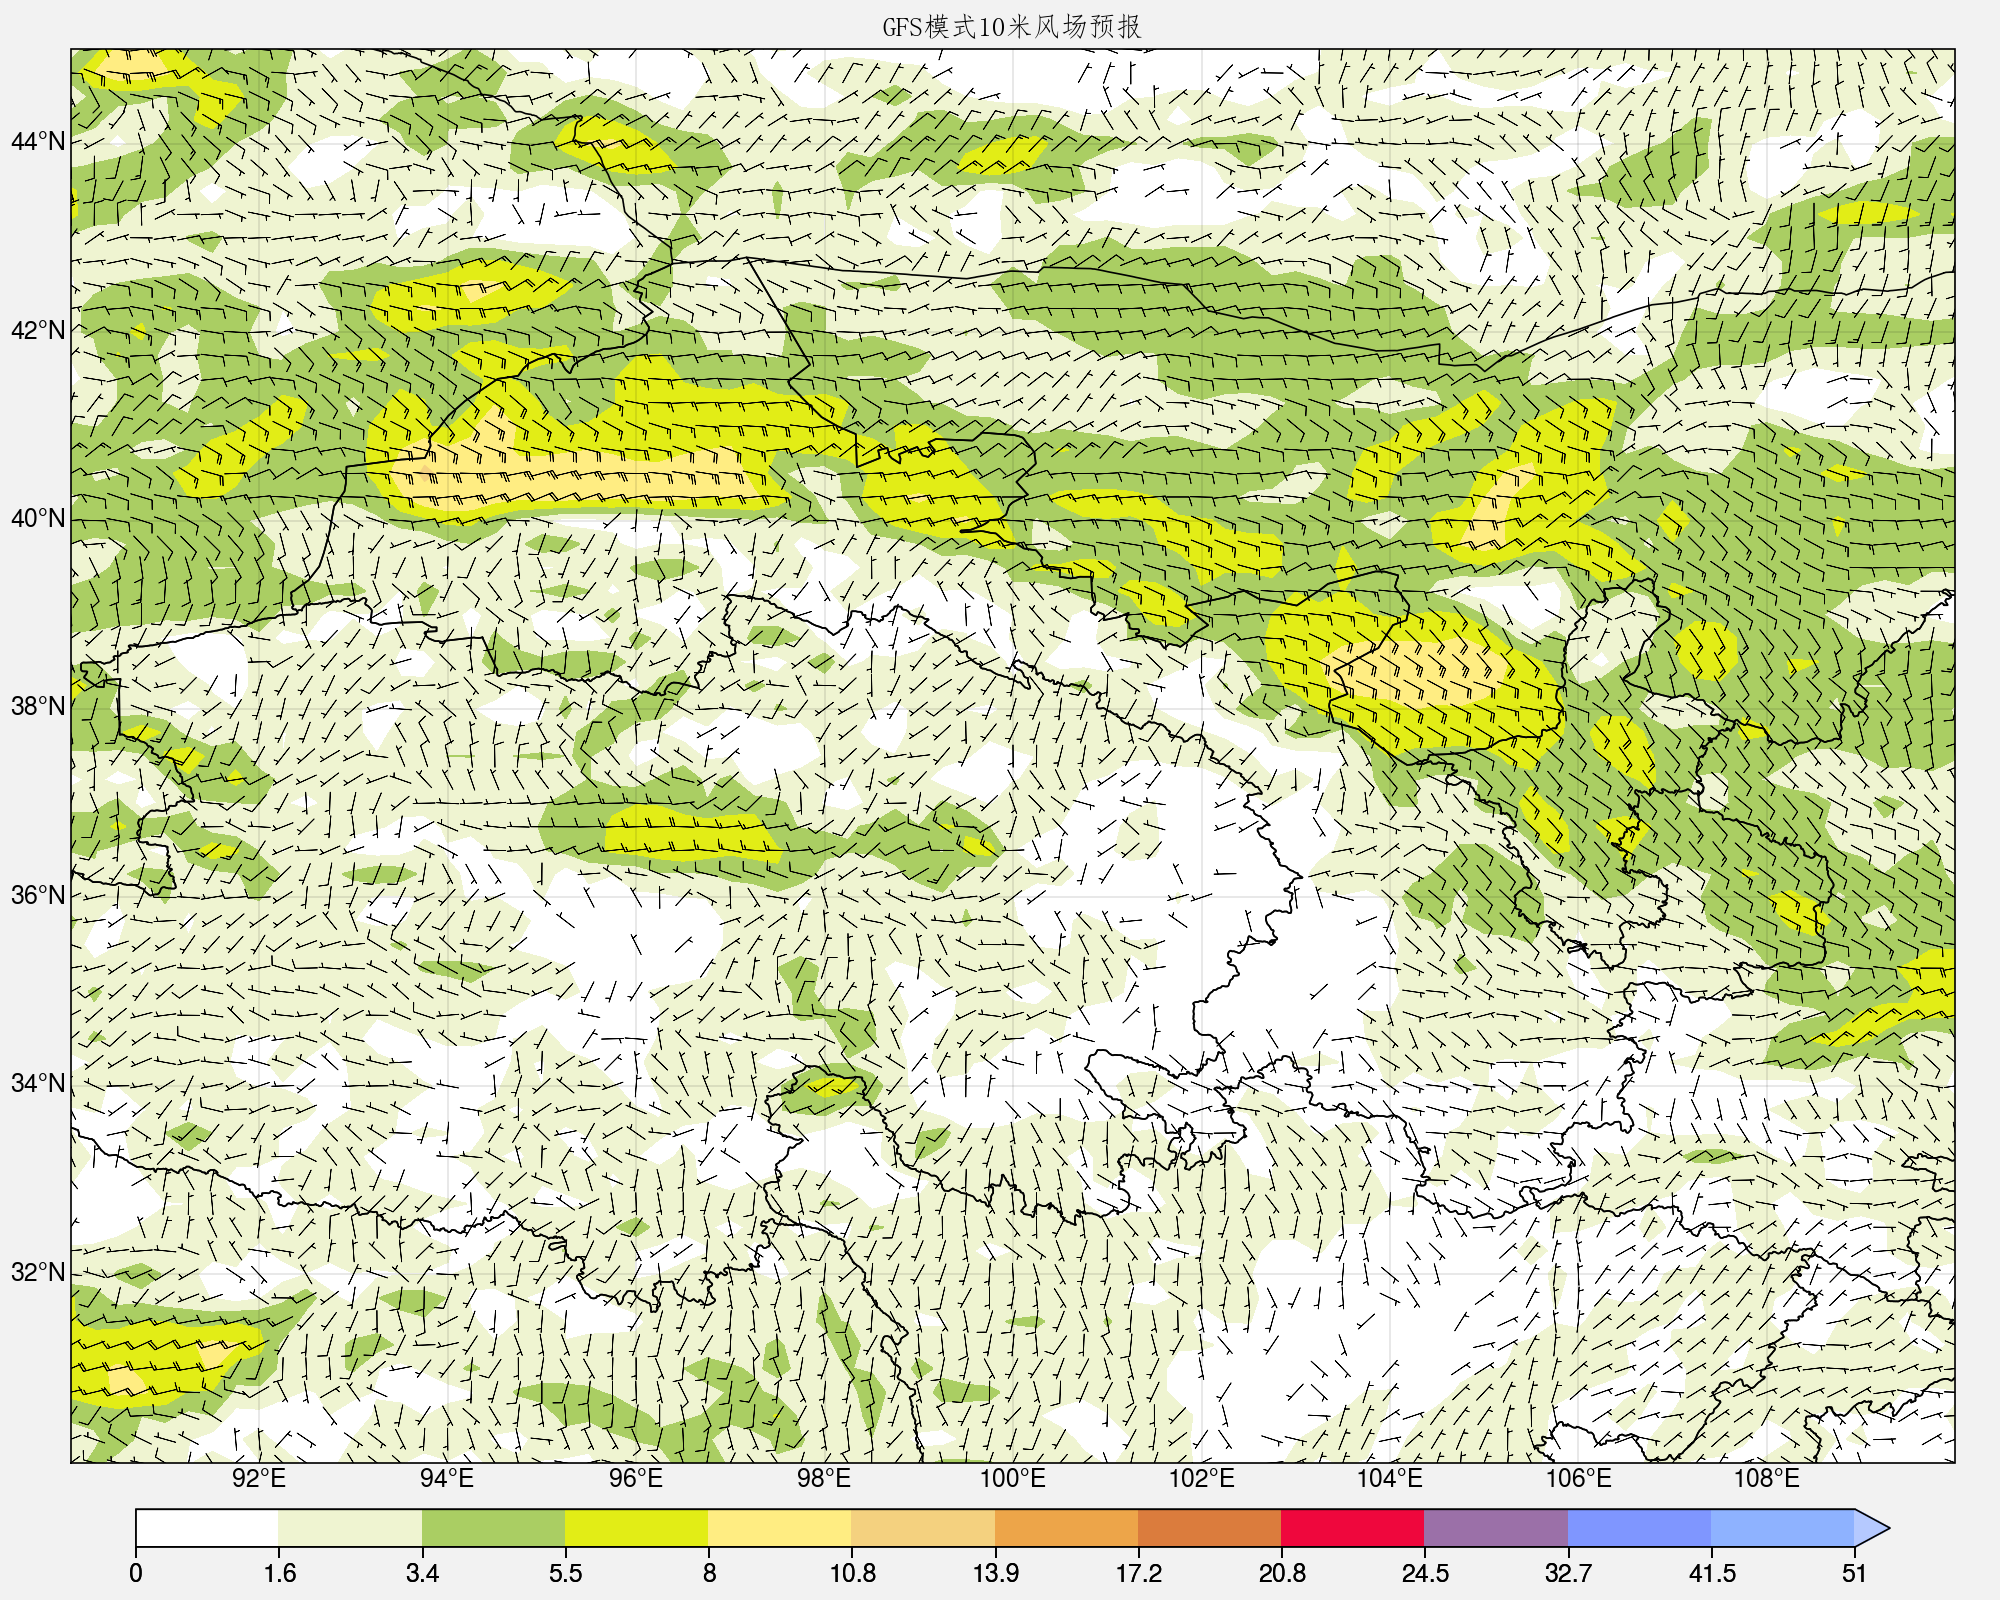

In [3]:
ds = xr.open_dataset('gfs.2021040300.pgrb2.0p25_10wind.f024', engine='cfgrib', backend_kwargs={'indexpath':''})
ds = ds.reindex(latitude=ds.latitude[::-1])
ds = ds.sel(longitude=slice(90,115),latitude=slice(30,45))

_space = 1
levels = np.array([0,1.6,3.4,5.5,8,10.8,13.9,17.2,20.8,24.5,32.7,41.5,51])

f, axs = plot.subplots(ncols=1, nrows=1, figsize=(10,8),proj='pcarree' )
axs.format(
    labels=True,latlines=2, lonlines=2,lonlim=(90,110),latlim=(30,45),
    suptitle=''
)

im = axs[0].contourf(ds.longitude, ds.latitude, ( ds.u10 ** 2 + ds.v10 ** 2 ) ** 0.5, cmap=cmaps.wind_17lev, levels=levels, extend='max')
axs[0].colorbar(im, loc='b', length=0.9)

axs[0].barbs(ds.longitude[::_space],ds.latitude[::_space],ds.u10[::_space,::_space], ds.v10[::_space,::_space],
    sizes=dict(emptybarb=0),length=4, lw=0.3,pivot='middle', barb_increments={'half':2,'full':4, 'flag':20})

axs[0].format(title='GFS模式10米风场预报',**cnfont_f)

shape_feature = ShapelyFeature(chn_geoms, ccrs.PlateCarree(), facecolor='none',edgecolor='k')
axs[0].add_feature(shape_feature)

#### 4 画降水

C:\Users\HP\miniconda3\envs\metenv\lib\site-packages\proplot\figure.py:1158: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  return super().colorbar(*args, cax=cax, **kwargs)
C:\Users\HP\miniconda3\envs\metenv\lib\site-packages\proplot\figure.py:1158: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  return super().colorbar(*args, cax=cax, **kwargs)


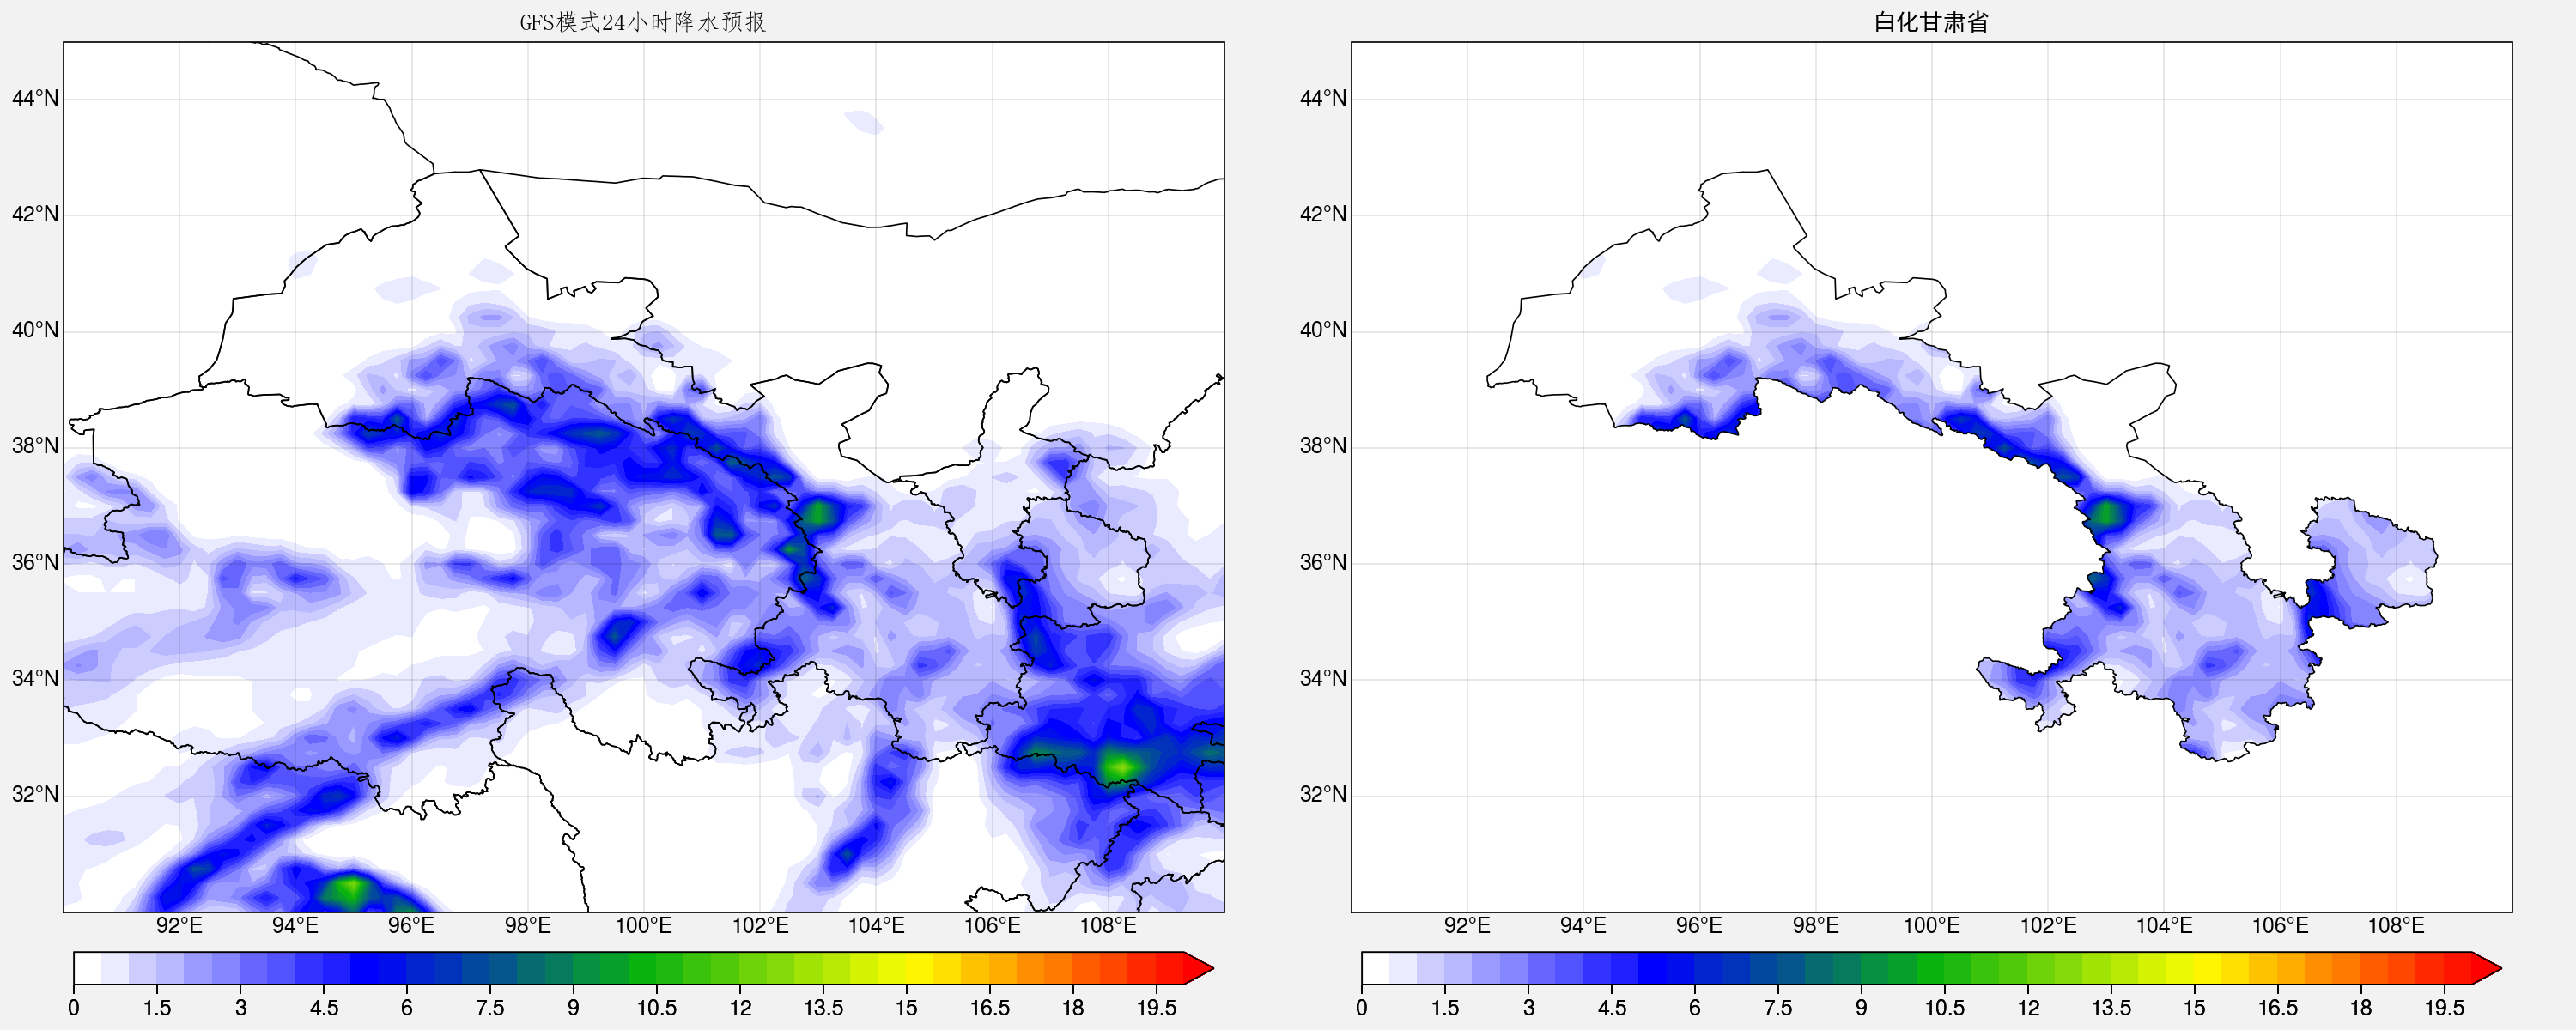

In [4]:
ds = xr.open_dataset('gfs.2021040300.pgrb2.0p25_tp.f024', engine='cfgrib', backend_kwargs={'indexpath':''})
ds = ds.reindex(latitude=ds.latitude[::-1])
ds = ds.sel(longitude=slice(90,115),latitude=slice(30,45))

f, axs = plot.subplots(ncols=2, nrows=1, figsize=(15,6),proj='pcarree' )
axs.format(
    labels=True,latlines=2, lonlines=2,lonlim=(90,110),latlim=(30,45),
    suptitle=''
)
 
im = axs[0].contourf(ds.longitude, ds.latitude, ds.tp, cmap=cmaps.WhBlGrYeRe, levels=np.linspace(0,20,41), extend='max')
axs[0].colorbar(im, loc='b', length=0.9)
axs[0].format(title='GFS模式24小时降水预报',**cnfont_f)

im = axs[1].contourf(ds.longitude, ds.latitude, ds.tp, cmap=cmaps.WhBlGrYeRe, levels=np.linspace(0,20,41), extend='max')
for collection in im.collections:
    collection.set_clip_path(path, ccrs.PlateCarree()._as_mpl_transform(axs[1]))
axs[1].colorbar(im, loc='b', length=0.9)
axs[1].format(title='白化甘肃省',**cnfont)


shape_feature = ShapelyFeature(chn_geoms, ccrs.PlateCarree(), facecolor='none',edgecolor='k')
axs[0].add_feature(shape_feature)

shp_gs = ShapelyFeature(gs_geoms,ccrs.PlateCarree(), facecolor='none',edgecolor='k')
axs[1].add_feature(shp_gs)